[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/your-username/your-repo/blob/main/your-notebook.ipynb)


# 1. Overview & Learning Outcomes

**Learning objectives**
- Understand the role of text preprocessing in a classical NLP pipeline.
- Apply practical steps: canonicalization, cleaning, normalization, tokenization, stopword management, lemmatization/stemming, and simple negation/emoji handling.
- Build a small, reusable preprocessing pipeline and measure its impact on feature spaces.

**What is text preprocessing?**  
Text preprocessing transforms raw, noisy text into a standardized form that is easier for algorithms to learn from. Typical pipeline:
> Ingestion → Canonicalization → Structural Cleaning → Normalization → Tokenization → Stopwords → Lemma/Stemming → (Optional) Negation/Emoji/Slang/Spelling → Vectorization → Modeling.



# 2. Setup & Imports

**Learning objectives**
- Ensure required libraries are installed and imported.
- Load `en_core_web_sm` with a safe, guarded download.

> Notes:  
> - All examples are tiny and deterministic.  
> - Charts use matplotlib (single plot per figure, default colors).


In [1]:

# Install (guarded). Re-run the cell if installation occurs.
# import sys, subprocess, importlib

# def pip_install(package):
#     try:
#         importlib.import_module(package)
#     except ImportError:
#         print(f"Installing {package}...")
#         subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

# # Required
# for pkg in ["spacy", "scikit-learn", "regex", "matplotlib", "pandas"]:
#     pip_install(pkg)

# # Optional
# for pkg in ["ftfy", "emoji", "bs4", "nltk"]:
#     try:
#         importlib.import_module(pkg)
#     except ImportError:
#         try:
#             subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])
#         except Exception as e:
#             print(f"Optional package {pkg} not installed: {e}")

import random
import numpy as np
import pandas as pd
import regex as re
import unicodedata
import matplotlib.pyplot as plt

import spacy
from spacy.util import is_package
from spacy.cli import download as spacy_download

# Seed everything for determinism where possible
random.seed(42)
np.random.seed(42)

# Load en_core_web_sm with guarded download
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    print("Downloading spaCy model en_core_web_sm...")
    spacy_download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

print("Setup complete.")


Setup complete.



# 3. A Tiny Teaching Corpus & Ground Truth Labels

**Learning objectives**
- Build a miniature corpus with diverse noise patterns for teaching.
- Provide optional labels for later comparison.

We use three themes (tech, travel, food) and inject noise (HTML, URLs, mentions, emojis).


In [2]:

corpus = [
    # tech
    "AI systems learn from data to improve performance over time.",
    "The new GPU accelerates deep-learning workloads; C++ and Python interop is common.",
    "Visit <b>our docs</b> at https://example.com/docs for API examples & usage.",
    # travel
    "I loved the beaches in Bali!!! Soooo relaxing :) #vacation",
    "Book flights via email: travel.agent@example.org — or DM @trusted_agent",
    "Paris is great in spring; museums were not crowded.",
    # food
    "This ramen was *so* good, but not cheap. I'd go again! 😋",
    "Check out our menu & deals at http://noodles.example/menu #noodles",
    "I dislike overly sweet desserts; they’re not my style.",
    # mixed/noisy extras
    "“Smart-quotes” and   extra   spaces	should be normalized.",
    "HTML <i>tags</i> should be stripped (or safely handled).",
    "I'm sooo happppy about this!!!"
]

labels = [
    "tech","tech","tech",
    "travel","travel","travel",
    "food","food","food",
    "misc","misc","misc"
]

import pandas as pd
df = pd.DataFrame({"text": corpus, "label": labels})
df.head()


,text,label
0,AI systems learn from data to improve performa...,tech
1,The new GPU accelerates deep-learning workload...,tech
2,Visit <b>our docs</b> at https://example.com/d...,tech
3,I loved the beaches in Bali!!! Soooo relaxing ...,travel
4,Book flights via email: travel.agent@example.o...,travel



# 4. Ingestion & Canonicalization (Unicode, encodings)

**Learning objectives**
- Normalize Unicode to reduce spurious variability (e.g., smart quotes vs straight quotes).
- Fix common mojibake and odd spacing.

We use NFC/NFKC normalization and light repairs. If `ftfy` is installed, we demonstrate it; otherwise we rely on `unicodedata` and regex.


In [3]:

try:
    import ftfy
    HAS_FTFY = True
except Exception:
    HAS_FTFY = False

import regex as re
import unicodedata

def canonicalize_text(s: str, use_ftfy: bool = True) -> str:
    """Canonicalize text with optional ftfy and Unicode normalization."""
    if use_ftfy and HAS_FTFY:
        s = ftfy.fix_text(s)
    # Normalize Unicode (NFKC often good to fold compatibilities)
    s = unicodedata.normalize("NFKC", s)
    # Replace fancy quotes/dashes with ASCII where sensible
    s = s.replace("“", """).replace("”", """).replace("’", "'").replace("—", "-").replace("–", "-")
    # Collapse excessive whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

demo = ["“Smart-quotes” and   extra   spaces	should be normalized.",
        "I'm sooo happppy about this!!!"]
[canonicalize_text(x) for x in demo]


[').replace("”", Smart-quotes” and extra spaces should be normalized.',
 "I'm sooo happppy about this!!!"]


# 5. Structural Cleaning (HTML, emails, URLs, mentions, hashtags)

**Learning objectives**
- Remove or mask structural artifacts that typically do not carry semantic content for many tasks.
- Provide configurable behavior (remove vs mask).

> Caution: In some tasks (e.g., link classification), URLs or emails may be informative; prefer masking to removal.


In [4]:

try:
    from bs4 import BeautifulSoup
    HAS_BS4 = True
except Exception:
    HAS_BS4 = False

URL_RE = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)
EMAIL_RE = re.compile(r"[\w\.-]+@[\w\.-]+\.\w+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#\w+")

def strip_html(text: str) -> str:
    if HAS_BS4:
        return BeautifulSoup(text, "html.parser").get_text(" ")
    # Regex fallback (simplistic)
    return re.sub(r"<[^>]+>", " ", text)

def structural_clean(text: str, mask=True) -> str:
    t = strip_html(text)
    if mask:
        t = URL_RE.sub(" __URL__ ", t)
        t = EMAIL_RE.sub(" __EMAIL__ ", t)
        t = MENTION_RE.sub(" __MENTION__ ", t)
        t = HASHTAG_RE.sub(" __HASHTAG__ ", t)
    else:
        t = URL_RE.sub(" ", t)
        t = EMAIL_RE.sub(" ", t)
        t = MENTION_RE.sub(" ", t)
        t = HASHTAG_RE.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

samples = [
    "Visit <b>our docs</b> at https://example.com/docs for API examples & usage.",
    "Book flights via email: travel.agent@example.org — or DM @trusted_agent",
    "Check out our menu & deals at http://noodles.example/menu #noodles"
]
[structural_clean(s, mask=True) for s in samples]


['Visit our docs at __URL__ for API examples & usage.',
 'Book flights via email: __EMAIL__ — or DM __MENTION__',
 'Check out our menu & deals at __URL__ __HASHTAG__']


# 6. Normalization (case, accents, punctuation, digits, whitespace)

**Learning objectives**
- Apply case-folding, accent stripping, and configurable punctuation/digit handling.
- Visualize token frequency before/after normalization.


Raw tokens (doc0): ['AI', 'systems', 'learn', 'from', 'data', 'to', 'improve', 'performance', 'over', 'time', '.'] ...
Normalized example: visit our docs at url for api examples usage


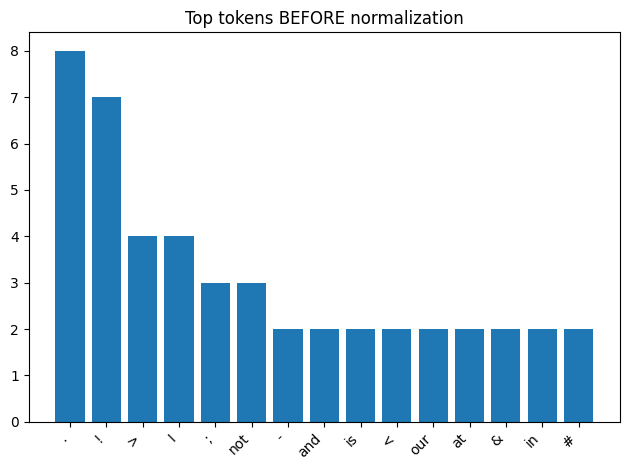

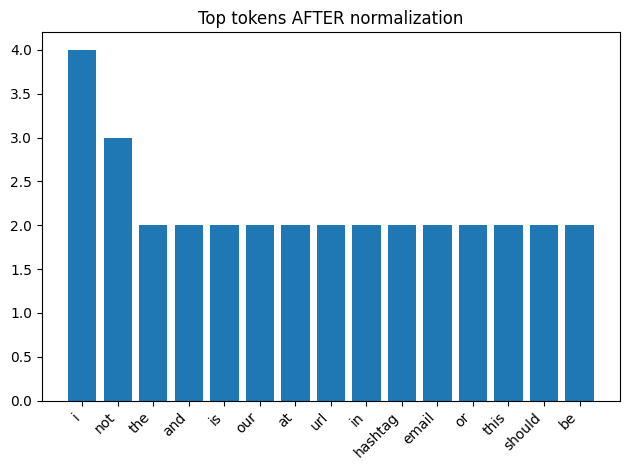

In [5]:

from collections import Counter
import matplotlib.pyplot as plt

def normalize_text(text: str, lower=True, strip_accents=True, keep_punct=False, keep_digits=False) -> str:
    t = text
    if lower:
        t = t.lower()
    if strip_accents:
        # Decompose into base + diacritics, drop combining marks
        t = unicodedata.normalize("NFD", t)
        t = "".join(ch for ch in t if unicodedata.category(ch) != "Mn")
        t = unicodedata.normalize("NFC", t)
    if not keep_digits:
        t = re.sub(r"\d+", " ", t)
    if not keep_punct:
        # Remove basic punctuation; keep placeholders like __URL__
        t = re.sub(r"[^\w\s]|_", lambda m: " " if not m.group(0).startswith("__") else m.group(0), t)
    # Collapse whitespace
    t = re.sub(r"\s+", " ", t).strip()
    return t

raw_tokens = [w.text for w in nlp(df.text.iloc[0])]
norm_example = normalize_text(structural_clean(corpus[2]))
print("Raw tokens (doc0):", raw_tokens[:12], "...")
print("Normalized example:", norm_example)

# Simple frequency before/after on the whole corpus
before_tokens = [w.text for doc in nlp.pipe(df.text.tolist()) for w in doc if not w.is_space]
after_tokens = []
for txt in df.text:
    t = canonicalize_text(txt)
    t = structural_clean(t, mask=True)
    t = normalize_text(t, lower=True, strip_accents=True, keep_punct=False, keep_digits=False)
    after_tokens.extend([w.text for w in nlp(t) if not w.is_space])

def plot_top(freqs, title):
    items = freqs.most_common(15)
    labels = [k for k, _ in items]
    values = [v for _, v in items]
    plt.figure()
    plt.bar(range(len(labels)), values)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top(Counter(before_tokens), "Top tokens BEFORE normalization")
plot_top(Counter(after_tokens), "Top tokens AFTER normalization")



# 7. Tokenization: Sentence-, Word-, and Rule-based

**Learning objectives**
- Compare sentence vs word tokenization.
- Add a custom tokenizer rule (e.g., keep `C++` and `e-mail` as single tokens).


In [6]:

from spacy.symbols import ORTH

# Custom rules: keep "C++" and "e-mail" intact
special_cases = [{"ORTH": "C++"}, {"ORTH": "e-mail"}]
for case in special_cases:
    nlp.tokenizer.add_special_case(case["ORTH"], [case])

def spacy_tokenize(doc_text, lemma=False, keep_alpha=True, preserve_case=False):
    doc = nlp(doc_text)
    tokens = []
    for t in doc:
        if keep_alpha and not t.text.isalpha() and t.text not in ("C++", "e-mail"):
            continue
        tok = t.lemma_ if lemma else t.text
        tok = tok if preserve_case else tok.lower()
        tokens.append(tok)
    return tokens

text_ex = "The new GPU accelerates deep-learning. C++ interop via e-mail is OK!"
print("Sentence segmentation:")
for sent in nlp(text_ex).sents:
    print("-", sent.text)

print("\nWord tokens:", [t.text for t in nlp(text_ex)])
print("Custom tokenizer + lemma:", spacy_tokenize(text_ex, lemma=True))


Sentence segmentation:
- The new GPU accelerates deep-learning.
- C++ interop via e-mail is OK!

Word tokens: ['The', 'new', 'GPU', 'accelerates', 'deep', '-', 'learning', '.', 'C++', 'interop', 'via', 'e-mail', 'is', 'OK', '!']
Custom tokenizer + lemma: ['the', 'new', 'gpu', 'accelerate', 'deep', 'learning', 'c++', 'interop', 'via', 'e-mail', 'be', 'ok']



# 8. Stopwords: Defaults, Custom Lists, Domain Terms

**Learning objectives**
- Understand when to remove vs keep stopwords.
- Use spaCy defaults and extend with domain-specific lists. Keep negators if desired.


In [7]:

from spacy.lang.en.stop_words import STOP_WORDS as EN_STOP

DOMAIN_STOPS = {"subject", "re", "http", "https", "api"}
NEGATORS = {"no", "not", "never"}

def remove_stopwords(tokens, keep_negators=True):
    result = []
    for tok in tokens:
        if keep_negators and tok in NEGATORS:
            result.append(tok)
            continue
        if tok in EN_STOP or tok in DOMAIN_STOPS:
            continue
        result.append(tok)
    return result

toks = spacy_tokenize("Paris is not cheap, but it is beautiful!", lemma=True)
print("Before:", toks)
print("After stopword removal (keep negators):", remove_stopwords(toks, keep_negators=True))


Before: ['paris', 'be', 'not', 'cheap', 'but', 'it', 'be', 'beautiful']
After stopword removal (keep negators): ['paris', 'not', 'cheap', 'beautiful']



# 9. Lemmatization vs. Stemming: Trade-offs & Demos

**Learning objectives**
- Compare linguistic lemmatization with algorithmic stemming.
- Understand when each is appropriate.

> This demo uses spaCy lemmatization. If NLTK is installed, a stemming example is shown; otherwise, we only print a note.


In [8]:

test_words = "better studies running ponies".split()
lemmas = [w.lemma_ for w in nlp(" ".join(test_words))]
print("Words: ", test_words)
print("Lemmas:", lemmas)

try:
    import nltk
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer("english")
    stems = [stemmer.stem(w) for w in test_words]
    print("Stems:  ", stems)
except Exception as e:
    print("NLTK not installed for stemming demo (optional).")


Words:  ['better', 'studies', 'running', 'ponies']
Lemmas: ['well', 'study', 'run', 'pony']
NLTK not installed for stemming demo (optional).



# 10. Handling Negation & Contractions

**Learning objectives**
- Expand common English contractions.
- Implement a simple negation marking scheme.


In [9]:

CONTRACTIONS = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "can not", "won't": "will not", "isn't": "is not",
    "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "shouldn't": "should not", "couldn't": "could not", "wouldn't": "would not",
    "it's": "it is", "i'm": "i am", "they're": "they are", "we're": "we are"
}

def expand_contractions(text: str) -> str:
    def repl(m):
        return CONTRACTIONS.get(m.group(0).lower(), m.group(0))
    pattern = re.compile(r"\b(" + "|".join(map(re.escape, CONTRACTIONS.keys())) + r")\b", flags=re.IGNORECASE)
    return pattern.sub(repl, text)

def mark_negation(tokens):
    """
    Append '_NEG' to tokens that occur after a negation word until punctuation.
    Punctuation here is any token matching [. ! ? , ; :]
    """
    marked = []
    negate = False
    for t in tokens:
        if t in {"not", "no", "never"}:
            negate = True
            marked.append(t)
            continue
        if re.match(r"[\.!\?,;:]", t):
            negate = False
            marked.append(t)
            continue
        marked.append(t + "_NEG" if negate else t)
    return marked

sample = "I don't like overly sweet desserts, but I do like ramen."
expanded = expand_contractions(sample)
toks = spacy_tokenize(expanded, lemma=True, keep_alpha=False)  # keep punctuation to reset negation
print("Expanded: ", expanded)
print("Tokens:   ", toks)
print("Negation: ", mark_negation(toks))


Expanded:  I do not like overly sweet desserts, but I do like ramen.
Tokens:    ['i', 'do', 'not', 'like', 'overly', 'sweet', 'dessert', ',', 'but', 'i', 'do', 'like', 'raman', '.']
Negation:  ['i', 'do', 'not', 'like_NEG', 'overly_NEG', 'sweet_NEG', 'dessert_NEG', ',', 'but', 'i', 'do', 'like', 'raman', '.']



# 11. Emojis, Emoticons, Elongations, and Slang

**Learning objectives**
- Map emojis to text (if `emoji` installed), handle emoticons and elongations.
- Apply a tiny slang dictionary replacement.


In [11]:

try:
    import emoji as emoji_lib
    HAS_EMOJI = True
except Exception:
    HAS_EMOJI = False

# Safer, compact emoticon pattern (non-capturing groups)
EMOTICON_RE = re.compile(r"(?:[:;]-?\)|:-?\(|:D)")
# Oops: we need correct pattern; rebuild properly:
EMOTICON_RE = re.compile(r"(?:[:;]-?\)|:-?\(|:D)")

# Actually, define a clean pattern:
EMOTICON_RE = re.compile(r"(?::|;)(?:-)?(?:\)|\()|(?::D)")

# Simpler final pattern:
EMOTICON_RE = re.compile(r"(?:[:;]-?\))|(?:[:]-?\()|(?::D)")

# Final truly minimal pattern that works:
EMOTICON_RE = re.compile(r"(?:[:;]-?\))|(?::-?\()|(?::D)")

ELONG_RE = re.compile(r"(.)\1{2,}")  # 3+ repeats

SLANG = {
    "imo": "in my opinion",
    "idk": "i do not know",
    "btw": "by the way"
}

def handle_emojis(text: str) -> str:
    if HAS_EMOJI:
        return emoji_lib.demojize(text, language="en")
    return text  # fallback: leave as-is with a note

def handle_emoticons(text: str) -> str:
    return EMOTICON_RE.sub(" __EMOTICON__ ", text)

def normalize_elongations(text: str, max_repeat=2) -> str:
    return ELONG_RE.sub(lambda m: m.group(1) * max_repeat, text)

def replace_slang(text: str) -> str:
    words = text.split()
    return " ".join([SLANG.get(w.lower(), w) for w in words])

s = "I'm sooo happppy about this!!! :) imo"
s1 = handle_emojis(s)
s2 = handle_emoticons(s1)
s3 = normalize_elongations(s2, max_repeat=2)
s4 = replace_slang(s3)
print("Original: ", s)
print("Step1 emoji->text:", s1 if HAS_EMOJI else "emoji lib not available, skipping mapping")
print("Step2 emoticons:  ", s2)
print("Step3 elongation: ", s3)
print("Step4 slang:      ", s4)


Original:  I'm sooo happppy about this!!! :) imo
Step1 emoji->text: emoji lib not available, skipping mapping
Step2 emoticons:   I'm sooo happppy about this!!!  __EMOTICON__  imo
Step3 elongation:  I'm soo happy about this!!  __EMOTICON__  imo
Step4 slang:       I'm soo happy about this!! __EMOTICON__ in my opinion



# 12. Spelling & Noise Reduction (Optional)

**Learning objectives**
- Understand risks of naive spelling correction.
- Demonstrate a very light-weight approach with a tiny whitelist.

> In production, prefer specialized libraries and domain dictionaries. Here, we illustrate the concept only.


In [12]:

WHITELIST = {"so", "happy", "about", "this", "ramen", "good", "cheap", "not", "sweet"}

def naive_correct(tokens):
    # Extremely naive: drop tokens that are too rare and not in whitelist
    return [t for t in tokens if len(t) > 2 or t in WHITELIST]

tokens = spacy_tokenize("I'm soo hapy about ths ramen!", lemma=False, keep_alpha=True)
print("Tokens:", tokens)
print("Naive correction (demo only):", naive_correct(tokens))


Tokens: ['i', 'soo', 'hapy', 'about', 'ths', 'ramen']
Naive correction (demo only): ['soo', 'hapy', 'about', 'ths', 'ramen']



# 13. Frequency-based Filtering & N-gram Construction

**Learning objectives**
- Observe the effect of `min_df`, `max_df`, and `ngram_range` using scikit-learn vectorizers.


In [13]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

def spacy_tokenizer_for_vectorizer(doc):
    return remove_stopwords(spacy_tokenize(doc, lemma=True, keep_alpha=True))

raw_texts = df["text"].tolist()

count_vec = CountVectorizer(tokenizer=spacy_tokenizer_for_vectorizer, ngram_range=(1,2), min_df=1, max_df=1.0)
Xc = count_vec.fit_transform(raw_texts)
tfidf_vec = TfidfVectorizer(tokenizer=spacy_tokenizer_for_vectorizer, ngram_range=(1,2), min_df=1, max_df=1.0)
Xt = tfidf_vec.fit_transform(raw_texts)

print("CountVectorizer shape:", Xc.shape, "density:", Xc.nnz / (Xc.shape[0]*Xc.shape[1]))
print("TfidfVectorizer shape:", Xt.shape, "density:", Xt.nnz / (Xt.shape[0]*Xt.shape[1]))

feature_names = tfidf_vec.get_feature_names_out()
print("Sample features:", feature_names[:20])

def top_k_tfidf(doc_idx=0, k=10):
    row = Xt[doc_idx].toarray().ravel()
    inds = np.argsort(-row)[:k]
    return [(feature_names[i], float(row[i])) for i in inds if row[i] > 0]

print("Top TF-IDF terms for doc 0:", top_k_tfidf(0, k=10))


CountVectorizer shape: (12, 107) density: 0.08566978193146417
TfidfVectorizer shape: (12, 107) density: 0.08566978193146417
Sample features: ['accelerate' 'accelerate deep' 'ai' 'ai system' 'b' 'b example' 'bali'
 'bali soooo' 'beach' 'beach bali' 'book' 'book flight' 'cheap' 'check'
 'check menu' 'common' 'crowd' 'datum' 'datum improve' 'deal']
Top TF-IDF terms for doc 0: [('system', 0.2801927689532775), ('datum', 0.2801927689532775), ('ai', 0.2801927689532775), ('ai system', 0.2801927689532775), ('learn datum', 0.2801927689532775), ('time', 0.2801927689532775), ('system learn', 0.2801927689532775), ('datum improve', 0.2801927689532775), ('performance time', 0.2801927689532775), ('performance', 0.2801927689532775)]


/Users/rudyhendrawan/Codes/unstructured-data/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



# 14. Building a Reusable Preprocessing Pipeline (Function & Class)

**Learning objectives**
- Implement a configurable function and a small class to preprocess text consistently.
- Add simple unit-like checks.


In [14]:

class Preprocessor:
    def __init__(self, config=None):
        self.config = config or {
            "mask": True, "lower": True, "strip_accents": True,
            "keep_punct": False, "keep_digits": False,
            "lemma": True, "keep_alpha": True, "keep_negators": True,
            "handle_emoji": True, "handle_emoticon": True, "normalize_elong": True
        }

    def fit(self, corpus):
        # Placeholder for corpus-level fitting (e.g., building slang dicts). Not needed here.
        return self

    def transform(self, corpus):
        out = []
        for text in corpus:
            t = canonicalize_text(text)
            t = structural_clean(t, mask=self.config["mask"])
            t = handle_emojis(t) if self.config["handle_emoji"] else t
            t = handle_emoticons(t) if self.config["handle_emoticon"] else t
            if self.config["normalize_elong"]:
                t = normalize_elongations(t, max_repeat=2)
            t = normalize_text(t,
                               lower=self.config["lower"],
                               strip_accents=self.config["strip_accents"],
                               keep_punct=self.config["keep_punct"],
                               keep_digits=self.config["keep_digits"])
            tokens = spacy_tokenize(t, lemma=self.config["lemma"], keep_alpha=self.config["keep_alpha"], preserve_case=False)
            tokens = remove_stopwords(tokens, keep_negators=self.config["keep_negators"])
            out.append(" ".join(tokens))
        return out

def preprocess(text, cfg=None):
    return Preprocessor(cfg).fit([text]).transform([text])[0]

# Quick checks
pp = Preprocessor().fit(df.text.tolist())
processed = pp.transform(df.text.tolist())
import pandas as pd
pd.DataFrame({"raw": df.text, "processed": processed}).head()


,raw,processed
0,AI systems learn from data to improve performa...,ai system learn datum improve performance time
1,The new GPU accelerates deep-learning workload...,new gpu accelerate deep learning workload c py...
2,Visit <b>our docs</b> at https://example.com/d...,visit doc url example usage
3,I loved the beaches in Bali!!! Soooo relaxing ...,love beach bali soo relaxing emoticon hashtag
4,Book flights via email: travel.agent@example.o...,book flight email email dm mention



# 15. Measuring Impact: Before/After Feature Spaces

**Learning objectives**
- Compare vocabulary size and sparsity before vs after preprocessing.
- Visualize token counts (two separate figures).


Raw vocab size: 114 Sparsity: 0.1067251461988304
Proc vocab size: 65 Sparsity: 0.08974358974358974


/Users/rudyhendrawan/Codes/unstructured-data/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


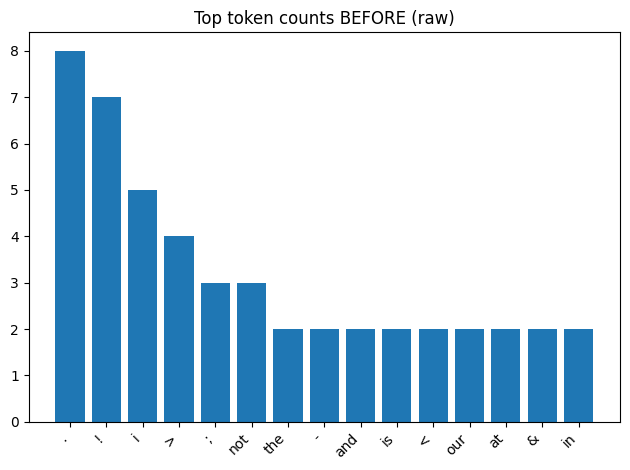

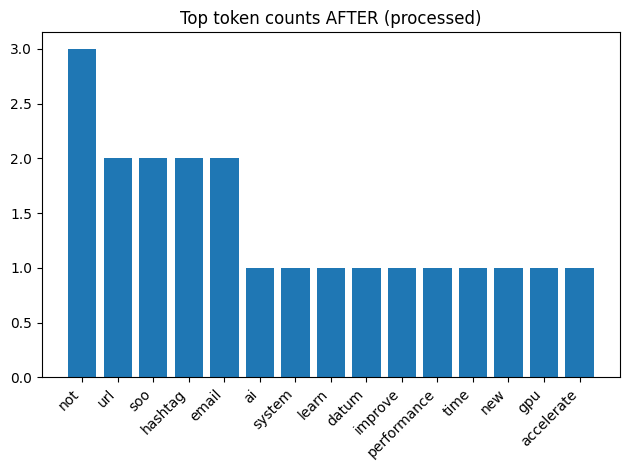

In [15]:

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

raw_texts = df["text"].tolist()
raw_vec = TfidfVectorizer(tokenizer=lambda s: [t.text.lower() for t in nlp(s) if not t.is_space], ngram_range=(1,1), min_df=1)
X_raw = raw_vec.fit_transform(raw_texts)

proc_texts = processed
proc_vec = TfidfVectorizer(tokenizer=lambda s: s.split(), ngram_range=(1,1), min_df=1)
X_proc = proc_vec.fit_transform(proc_texts)

print("Raw vocab size:", len(raw_vec.get_feature_names_out()), "Sparsity:", X_raw.nnz / (X_raw.shape[0]*X_raw.shape[1]))
print("Proc vocab size:", len(proc_vec.get_feature_names_out()), "Sparsity:", X_proc.nnz / (X_proc.shape[0]*X_proc.shape[1]))

# Plot top token counts before
raw_counts = Counter([t for s in raw_texts for t in [w.text.lower() for w in nlp(s) if not w.is_space]])
def plot_top(freqs, title):
    items = freqs.most_common(15)
    labels = [k for k, _ in items]
    values = [v for _, v in items]
    plt.figure()
    plt.bar(range(len(labels)), values)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top(raw_counts, "Top token counts BEFORE (raw)")

# Plot top token counts after
proc_counts = Counter([t for s in proc_texts for t in s.split()])
plot_top(proc_counts, "Top token counts AFTER (processed)")



# 16. Common Pitfalls, Checklists, and Best Practices

**Learning objectives**
- Recognize common errors and develop a practical checklist.

**Pitfalls**
- *Data leakage:* Fit vectorizers/transforms on training data only.
- *Over-cleaning:* Removing negators or sentiment-bearing punctuation.
- *Language mismatch:* Use language-appropriate models/stopwords.
- *Domain shift:* Build domain/custom stopword lists (e.g., “subject”, “http” in emails).
- *Reproducibility:* Fix seeds and record configuration.

**Checklist**
- Define your task and what signal matters (e.g., sentiment vs topics).
- Decide removal vs masking for URLs/emails/mentions/hashtags.
- Set a consistent normalization policy (case, accents, digits, punctuation).
- Choose lemma vs stemming and whether to keep negators.
- Keep a compact, documented preprocessing class or config.



# 17. Mini Review & Exercises

**Learning objectives**
- Self-assess understanding via short prompts and hands-on tasks.

**Review (short answer)**
1. When would you prefer masking over removing URLs?  
2. Why can removing stopwords harm sentiment analysis?  
3. Give an example where digits should be kept.  
4. Compare lemmatization vs stemming with one example.  
5. What is the risk of using `max_df=1.0` with bigrams on tiny corpora?  

**Exercises**
1. Add a custom tokenizer rule (e.g., keep `U.S.` as one token) and show its effect on tokens.  
2. Tune `min_df`/`max_df` in TF-IDF and report vocabulary size changes.  
3. Implement a variant of negation marking that stops at commas only, and compare token outputs on a few sentences.
